In [75]:
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px

In [16]:
# I will work on building and analysing PCA on my dataset
# Load dataset from npz files
dict_X = np.load('../dataset/X.npz')
dict_y = np.load('../dataset/y.npz')
# Store arrays from dictionary
X = dict_X['arr_0']
y = dict_y['arr_0']

In [328]:
n_PCA = 50
pca = PCA(n_components=n_PCA, whiten=True, svd_solver='randomized', random_state=42)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=True)

In [329]:
# transform data into PCA space
X_pca = pca.transform(X)
print(f"Original data has {X.shape[0]} entries and {X.shape[1]} features.")
print(f"The projected {X_pca.shape[0]} entries have {X_pca.shape[1]} features in the reduced space by PCA.")

Original data has 2414 entries and 32256 features.
The projected 2414 entries have 50 features in the reduced space by PCA.


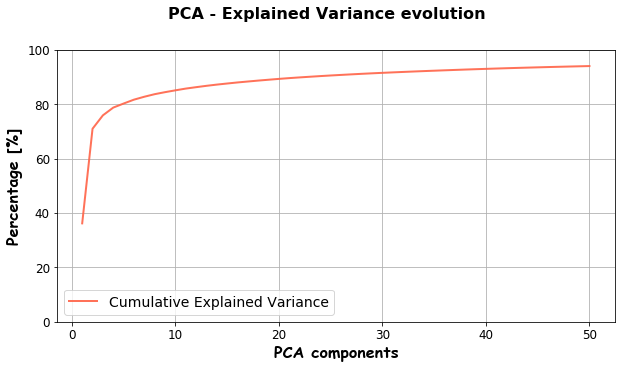

In [31]:
# plot evolution of explained variance (asses dimensionality reduction)

fig = plt.figure(figsize=[10,5])
fig.suptitle('PCA - Explained Variance evolution', size=16, weight='bold',y=1)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])

x_plot = np.linspace(1,len(y),len(y)).astype(int)
y_plot = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(x_plot[:n_PCA], y_plot*100, ls='-', color ='tomato' , lw=2, alpha=0.9, label='Cumulative Explained Variance')
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
legend_prop = {'size':14,'weight':'ultralight'}
ax1.legend(prop=legend_prop)
label_prop = {'size':16,'weight':'bold','family':'fantasy'}
ax1.set_xlabel('PCA components',fontdict=label_prop)
ax1.set_ylabel('Percentage [%]',fontdict=label_prop)


ylabels = np.arange(0,101,20)
ax1.ylim = (0,100)
ax1.set_yticks(ylabels)
ax1.grid(axis='x')
ax1.grid(axis='y')

# fig.savefig('../images/pca_50.png',dpi=800,bbox_inches='tight')


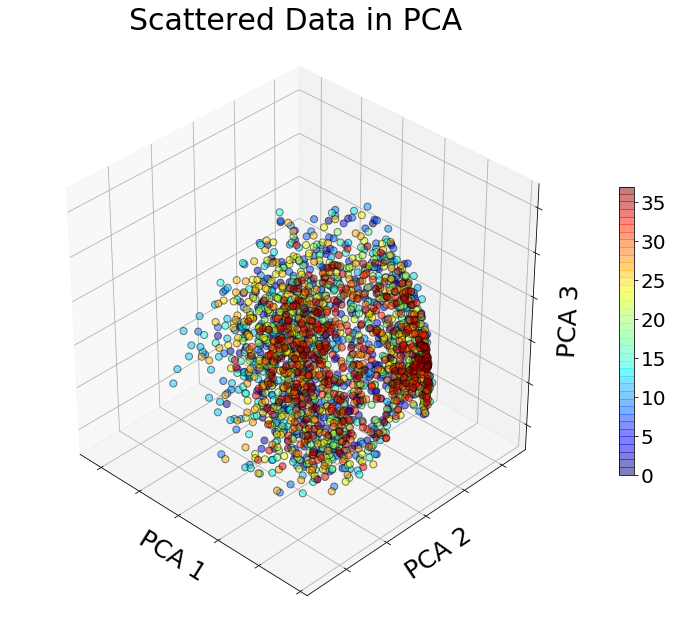

In [330]:
# try to see groups in 3D PCA

%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, elev=35, azim=134)
scaPlot = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y,
           cmap=plt.cm.get_cmap('jet', 38), edgecolor='k', s = 50, alpha = 0.5)

ax.set_title("Scattered Data in PCA", fontsize=30,y=1.1)
ax.set_xlabel("PCA 1", fontsize=25)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PCA 2", fontsize=25)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PCA 3", fontsize=25)
ax.w_zaxis.set_ticklabels([])

c_ticks = np.arange(0,36,5)
cbar = fig.colorbar(scaPlot,shrink=0.5,ticks=c_ticks)
cbar.ax.tick_params(labelsize=20)

# fig.savefig('../images/sca_data_pca.png',dpi=800,bbox_inches='tight')


In [48]:
# add a 4D PCA using plotly (colors and symbols)

fig = px.scatter_3d(x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2], color=X_pca[:, 3], symbol=y)
fig.show()

The figures could suggest that in the PCA space, the different classes (or persons) could be classified using SVM with RBF.

#### PCA with a Gaussian kernel (k-PCA)

The Gaussian kernel is the function: $\displaystyle\mathrm{exp}\left(- \frac{\left\|\mathbf{x}-\mathbf{y}\right\|^2}{2\sigma^2} \right)$, where $\left\|\mathbf{x}-\mathbf{y}\right\|$ is the distance between two entries on our data. The choice of parameter $\sigma$ directly determines the performance of k-PCA.

As discussed in the paper by Q. Wang (2012, arXiv:1207.3538), if we want to separate different classes in the new feature space, then $\sigma$ should be smaller than inter-classes distances and larger than inner-classes distances.

For an unsupervised model one could use:

$\displaystyle\sigma = 5\;\mathop{\mathrm{mean}}_{i}\,(d^{NN}_i)$,

where $d^{NN}_i$ denotes the distance from a data point $\mathbf{x}_i$ to its nearest neighbour.

In [88]:
# Choice of parameter \sigma for kPCA with Gaussian kernel

pdist_all = pdist(X)

In [120]:
# find the distance to NN per point
pdist_sq = squareform(pdist_all)

# exclude the diagonal of zeros
np.fill_diagonal(pdist_sq, np.inf)
# compute d^{NN}_i
min_pdist = pdist_sq.min(axis=0)


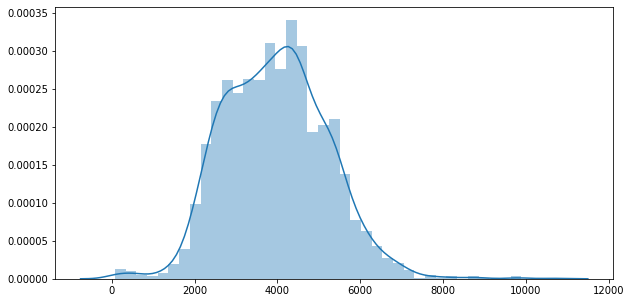

In [122]:
# plot the distribution of d^{NN}_i

fig = plt.figure(figsize=[10,5])
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
axis = fig.add_subplot(spec[0,0])
plot_var = sns.distplot(min_pdist)

In [ ]:
# Compute the euclidean distance between points in our classes

pdist_list = [pdist(X[y == label,:]) for label in np.unique(y)]

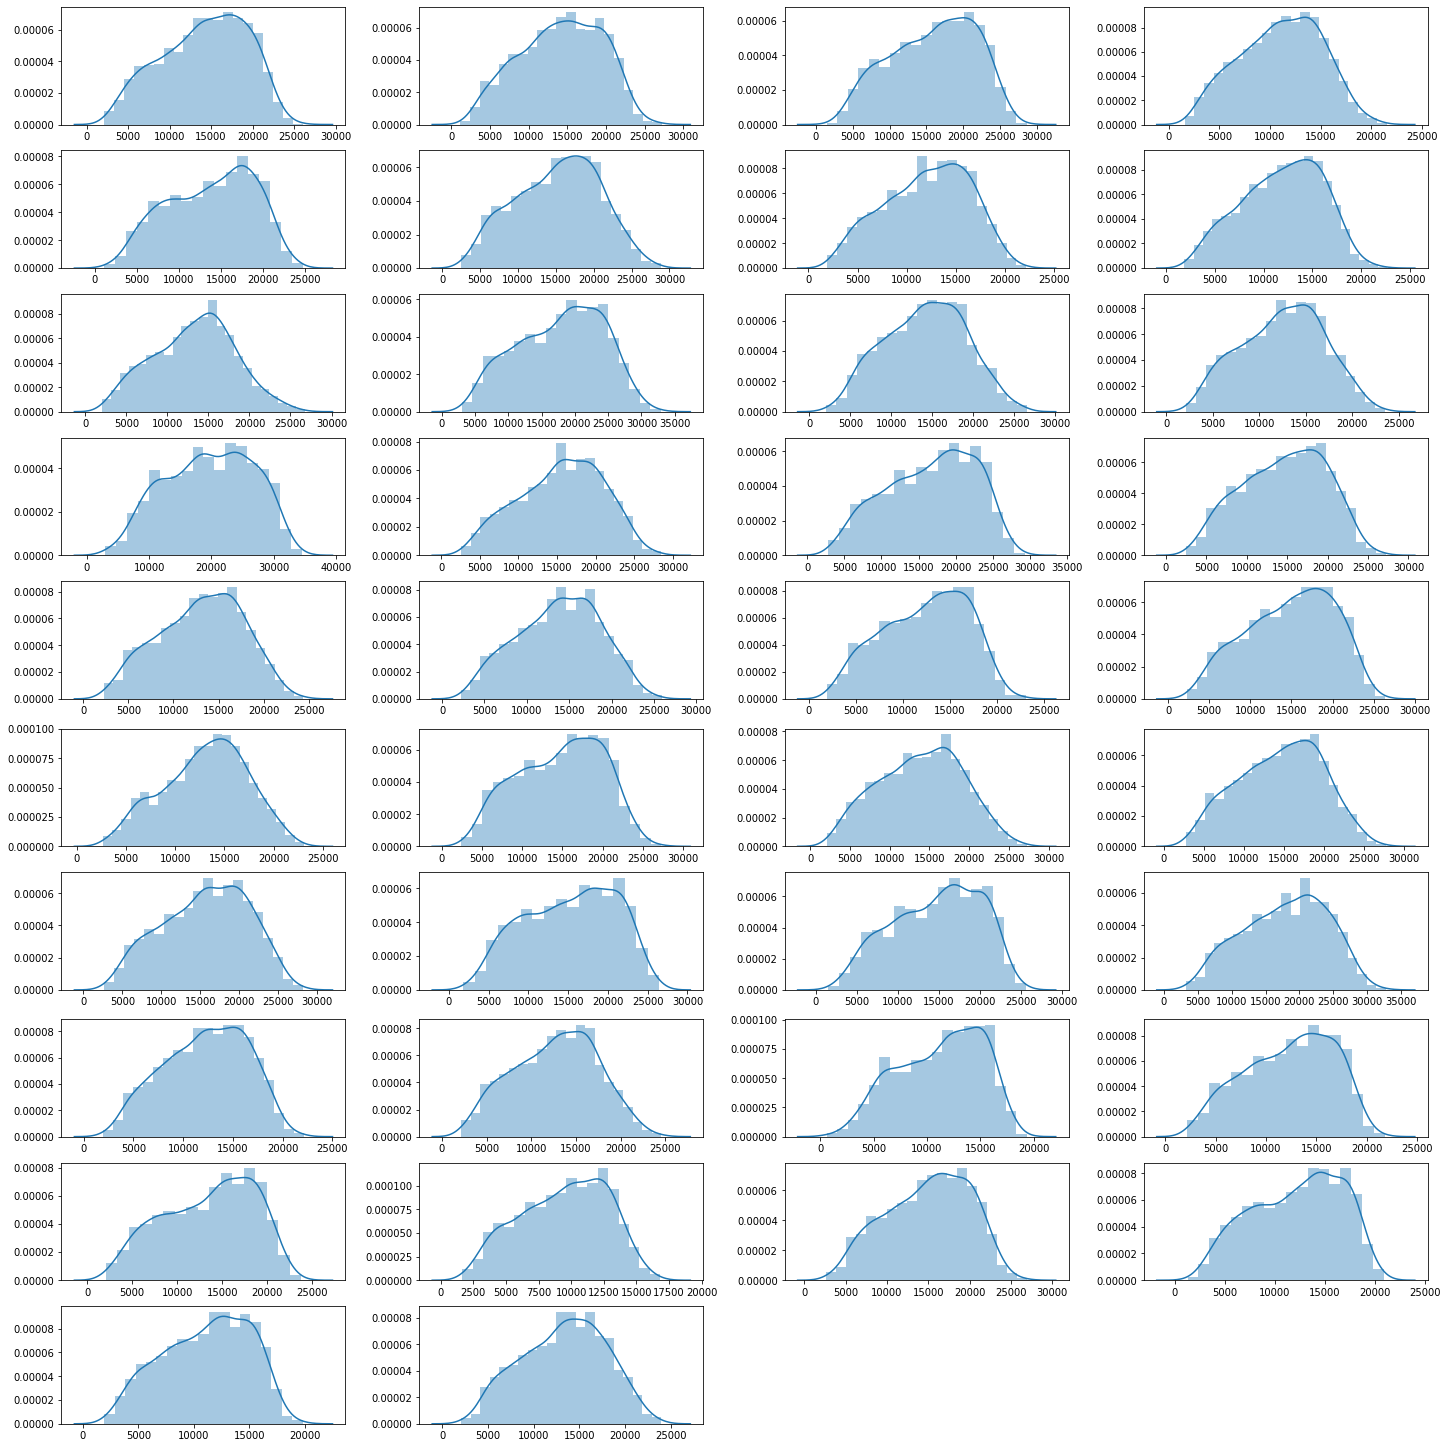

In [71]:
# plot distribution of distances in groups
fig = plt.figure(figsize=[20,20],constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=10, figure=fig)

for i in range(len(np.unique(y))):
    row = int(np.floor(i/4))
    col = i%4
    axis = fig.add_subplot(spec[row,col])
    plot_var = sns.distplot(pdist_list[i])


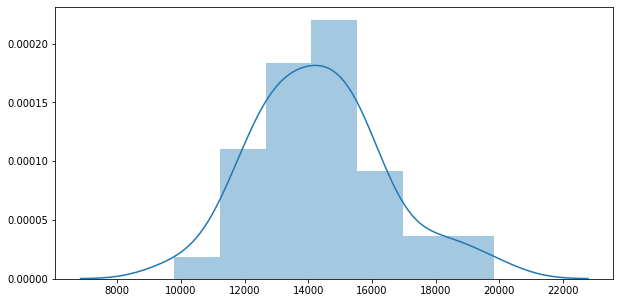

In [73]:
# plot the distribution of medians of different groups

median_pdists = [np.median(pt_dist) for pt_dist in pdist_list]

fig = plt.figure(figsize=[10,5])
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
axis = fig.add_subplot(spec[0,0])
plot_var = sns.distplot(median_pdists)


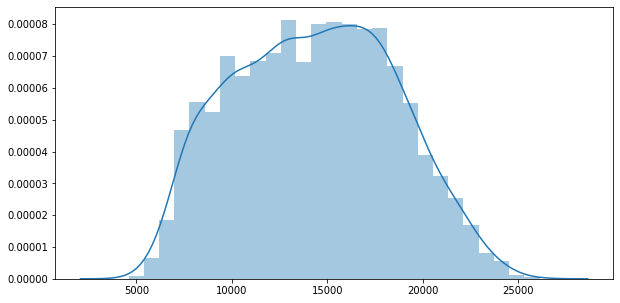

In [87]:
# interesting insight: distance between groups!
dist_1_2 = cdist(X[y == 0,:],X[y == 37,:])
dist_1_2_array = dist_1_2.reshape(-1)

fig = plt.figure(figsize=[10,5])
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
axis = fig.add_subplot(spec[0,0])
plot_var = sns.distplot(dist_1_2_array)


In [331]:
# Now we would go to kPCA to see the results
print(f"Following Q. Wang paper, then sigma = {round(np.mean(min_pdist)*5,2)}")

sigma = np.mean(min_pdist)*5
gamma_rbf = 1/(2*sigma**2)

kPCA = KernelPCA(n_components=50, kernel='rbf', gamma=gamma_rbf, random_state=42, eigen_solver='arpack')
X_kPCA = kPCA.fit_transform(X)


Following Q. Wang paper, then sigma = 19816.04


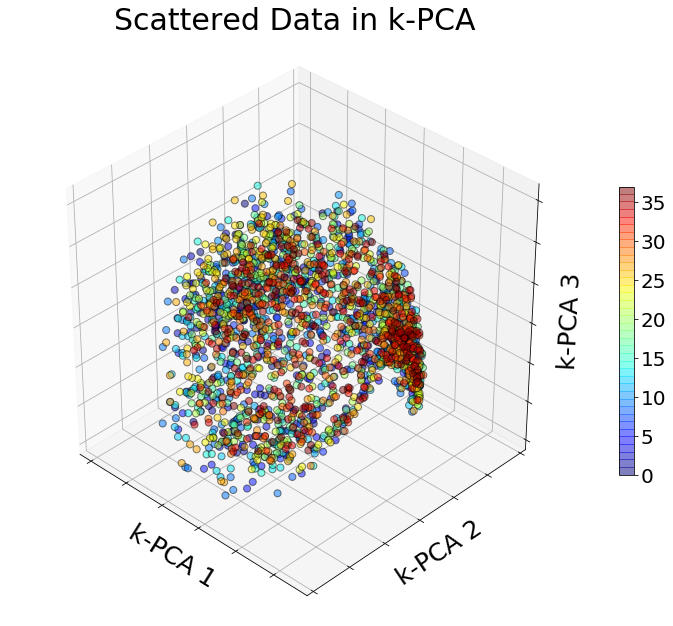

In [303]:
# try to see groups in 3D k-PCA

%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, elev=35, azim=134)
ax.scatter(X_kPCA[:, 0], X_kPCA[:, 1], X_kPCA[:, 2], c=y[:],
           cmap=plt.cm.get_cmap('jet', 38), edgecolor='k', s = 50, alpha = 0.5)

ax.set_title("Scattered Data in k-PCA", fontsize=30,y=1.1)
ax.set_xlabel("k-PCA 1", fontsize=25)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("k-PCA 2", fontsize=25)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("k-PCA 3", fontsize=25)
ax.w_zaxis.set_ticklabels([])

c_ticks = np.arange(0,36,5)
cbar = fig.colorbar(scaPlot,shrink=0.5,ticks=c_ticks)
cbar.ax.tick_params(labelsize=20)

# fig.savefig('../images/sca_data_kpca.png',dpi=800,bbox_inches='tight')


In [332]:
# Add groups to figure out clustering by plotting
labels = np.unique(y)
choose_group = 38
idx = [y == label for label in labels[:choose_group]]
idx_or = np.logical_or.reduce(idx)

In [334]:
fig = px.scatter_3d(x=X_kPCA[idx_or, 0], y=X_kPCA[idx_or, 1], z=X_kPCA[idx_or, 2], color=y[idx_or])
fig.show()

In [335]:
# save data variables from pca and k-pca
# save to npz file
np.savez_compressed('../dataset/X_PCA.npz', X_pca)
np.savez_compressed('../dataset/X_kPCA.npz', X_kPCA)